# WP6
## Author: John D'Angelo
### Fall 2018, University of Texas at Austin

Text(0.5,0,'Pore Pressure [MPa]')

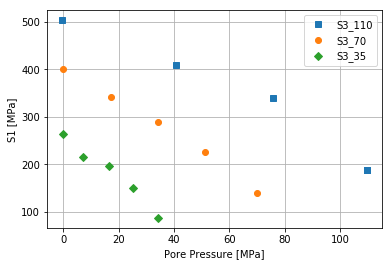

In [1]:
#import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
%matplotlib inline

#Read data
df = pd.read_csv('DarleyDale.csv')

#Check that data was digitized properly
fig, ax = plt.subplots()
df.plot(x='P_110',y='S1_110',ax=ax,linestyle='',marker='s',label='S3_110')
df.plot(x='P_70',y='S1_70',ax=ax,linestyle='',marker='o',label='S3_70')
df.plot(x='P_35',y='S1_35',ax=ax,linestyle='',marker='D',label='S3_35')
ax.grid()
ax.legend()
ax.set_ylabel('S1 [MPa]')
ax.set_xlabel('Pore Pressure [MPa]')

1) Determination of shear and tensile strength

a. Determine the best fitting parameters of a Coulomb criterion:  
$\sigma_{1} = UCS + q\sigma_{3}$

In [3]:
from scipy import optimize

def coulombCriteria(args):
    
    error = 0    
    nums = [35,70,110]
    for ID in nums:
        Ppore = df['P_'+str(ID)]
        S1_data = df['S1_'+str(ID)]
        S3_data = ID
        sigma_1 = S1_data - Ppore
        sigma_3 = S3_data - Ppore
        LHS = args[0] + args[1]*sigma_3
        error += (sigma_1-LHS)**2
    error = np.sqrt(np.mean(error))
    return error

params = optimize.minimize(coulombCriteria, [0,0])
(UCS,q)=params.x
print('Best fit parameters for Darley Dale Sandstone data:')
print('q = ',q)
print('UCS = ',UCS)

Best fit parameters for Darley Dale Sandstone data:
q =  4.152349160872966
UCS =  89.42919493988543


b. Determine corresponding values of cohesive strength $S_{0}$ and friction angle $\phi$ from point (a) and draw the shear failure line together with Mohr circles at failure.

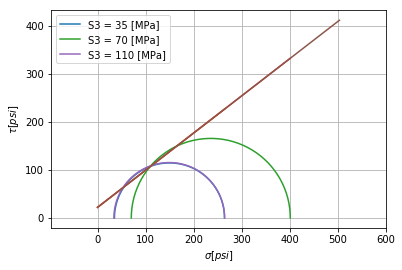

In [9]:
#This cell calculates the failure envelope for the experimental material
#Then the data from each of the three experimental trials is compared 
#against the failure envelope to at which datapoint failure likely initiated.

#Calculate failure envelope 
frictAngle = np.arcsin((q-1)/(q+1))
S0 =  (UCS/(2*np.sqrt(q)))
tau_fail = lambda sig: S0+ sig*np.tan(frictAngle)


fig,ax=plt.subplots()  
nums = [35,70,110]
k = 0
for i in nums:
  
    #Find failure location along line defined by fit to experimental data
    Pp = np.array(df['P_'+str(i)])
    sig3 = i - Pp
    sig1 = np.array(df['S1_'+str(i)])-Pp
    for j in range(0,len(sig1)):
        exit = False
        #Setup Plots      
        circle1X=[]
        circle1Y=[]
        a=sig1[j]
        b = sig3[j]
        for z in np.linspace(0,-np.pi):
            circle1X.append((b-a)/2*np.cos(z) + (a+(b-a)/2))
            circle1Y.append((b-a)/2*np.sin(z) )
        for j, fail_point in enumerate(tau_fail(np.array(circle1X))):
            if circle1Y[j] >= fail_point:
                ax.plot(circle1X,circle1Y,label = 'S3 = '+str(i) + ' [MPa]')
                exit = True
                break
        if exit:
            break

    #Plot failure envelope
    sigma = np.linspace(0,np.max(sig1))
    ax.plot(sigma,tau_fail(sigma))
    ax.set_xlabel(r'$\sigma [psi]$')
    ax.set_ylabel(r'$\tau [psi]$')
    ax.grid()
    ax.legend()
    plt.axis('equal')
    k+=1


c. Determine corresponding fitting parameters for a Drucker-Prager criterion and plot experimental data in a $I_{1}$ v.s. $\sqrt{J_{2}}$ space.

In [12]:
from scipy import optimize

def dockpragCriteria(args):
    
    error = 0    
    nums = [35,70,110]
    for ID in nums:
        Ppore = df['P_'+str(ID)]
        S1_data = df['S1_'+str(ID)]
        S3_data = ID
        sigma_1 = S1_data - Ppore
        sigma_3 = S3_data - Ppore
        I1 = sigma_1 + 2*sigma_3
        sqrJ2 = np.abs(sigma_1-sigma_3)/np.sqrt(3)
        LHS = args[0] + args[1]*I1
        error += (sqrJ2 - LHS)**2
    error = np.sqrt(np.mean(error))
    return error

params = optimize.minimize(dockpragCriteria, [0,0])
(A,B)=params.x

print('Best fit parameters:')
print('A = ',A)
print('B = ',B)

Best fit parameters:
A =  24.08188794702204
B =  0.2996256403811569


Text(0,0.5,'sqrt J2 [MPa]')

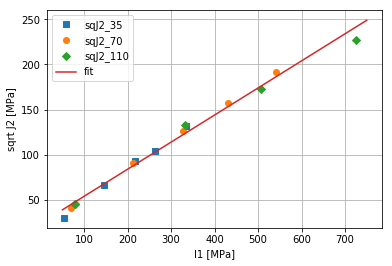

In [13]:
fig, ax = plt.subplots()
mrks=['s','o','D']
#Shift experimental data into I1 sqrt(J2) space
nums = [35,70,110]
for j,i in enumerate(nums):
    sig1 = df['S1_'+str(i)]-df['P_'+str(i)]
    sig3 = i - df['P_'+str(i)]
    df['I1_'+str(i)] = (sig1) + 2*sig3
    df['sqJ2_'+str(i)] = np.abs(sig1-sig3)/np.sqrt(3)
    df.plot(x='I1_'+str(i),y='sqJ2_'+str(i),ax=ax,linestyle='',marker=mrks[j])
Irange=np.linspace(50,750)
ax.plot(Irange,A+B*Irange,label='fit')    

ax.grid()
ax.legend()
ax.set_xlabel('I1 [MPa]')
ax.set_ylabel('sqrt J2 [MPa]')


d. Compute corresponding tensile strength assuming a reasonable ratio of  unconfined compression strength to tensile strength (see Jaeger's book).

In [7]:
# ratio for sandstone from Fundamentals of 
# Rock Mechanics by Jaeger et al. 4th Edition, pg 97
m = 15

Ts = UCS/m
print("Tensile Strengh: ", Ts, " [MPa]")

Tensile Strengh:  5.961946329325696  [MPa]


2) Shear and tensile failure in vertical and deviated wellbores

In [8]:
#Here I am defining all the convenience functions I will use for the analysis

def classifyRegime(Sv,Shmax,Shmin, alpha,Pw=None):
    if(Sv>Shmax and Shmax >Shmin):
        name="Normal"
        if Pw == None:
            Pw = 32
        return(alpha[0],90,0,Pw,name)
    elif(Shmax>Sv and Sv>Shmin):
        name="Strike-Slip"
        if Pw == None:
            Pw = 40
        return(alpha[1],0,90,Pw,name)
    elif(Shmax>Shmin and Shmin>Sv):
        name="Reverse"
        if Pw == None:
            Pw = 52
        return(alpha[2],0,0,Pw,name)

    else:
        print("Error: Potential issue with stresses provided")
        return "Bad Input"

def rotationPG(alpha,beta,gamma,units = "degrees"):
    
    if units.lower().strip().find("deg")!=-1:
        alpha = np.deg2rad(alpha);
        beta = np.deg2rad(beta);
        gamma = np.deg2rad(gamma);
        
    #Easier than calling cos and sin function over and over    
    cA = np.cos(alpha)
    sA = np.sin(alpha)
    cB = np.cos(beta)
    sB = np.sin(beta)
    cG = np.cos(gamma)
    sG = np.sin(gamma)
    
    return np.round(np.array([[cA*cB, sA*cB, -sB],
                    [(cA*sB*sG - sA*cG),(sA*sB*sG+cA*cG), cB*sG ],
                    [(cA*sB*cG + sA*sG),(sA*sB*cG-cA*sG), cB*cG ]]),3)

def rotationGW(delta,phi,units = "degrees"):
    
    if units.lower().strip().find("deg")!=-1:
        d = np.deg2rad(delta);
        p = np.deg2rad(phi);
        
    #Easier than calling cos and sin function over and over    
    cd = np.cos(d)
    cp = np.cos(p)
    sd = np.sin(d)
    sp = np.sin(p)
    
    
    return np.array([[-cd*cp, -sd*cp, sp],
                    [sd, -cd, 0 ],
                    [cd*sp, sd*sp, cp]])

def devStress(sigZZ,sigTT,tau):
    I = (sigZZ+sigTT)/2
    D = np.sqrt(((sigZZ-sigTT)/2)**2 + tau**2)
    return (I+D, I-D)

def stressTensor(Sv,Shmax,Shmin):
    sValues = [Sv,Shmax,Shmin]
    sValues = sorted(sValues,reverse=True)
    return np.array([[sValues[0],0,0],
                    [0,sValues[1],0],
                    [0,0,sValues[2]]])

def wellWallStress(args):
    (stressW,Pp,Pw,v,th)=args
    theta = np.radians(th)
    sig11 = stressW[0,0]
    sig22 = stressW[1,1]
    sig33 = stressW[2,2] 

    sig23 = stressW[1,2]
    sig12 = stressW[0,1]
    sig13 = stressW[0,2]


    sigRR = Pw-Pp
    sigTT = sig11 + sig22 - 2*(sig11-sig22)*np.cos(2*theta) - 4*sig12*np.sin(2*theta) - sigRR
    tau = 2*(sig23*np.cos(theta) - sig13*np.sin(theta))
    sigZZ = sig33 - 2*v*(sig11-sig22)*np.cos(2*theta) - 4*v*sig12*np.sin(2*theta)

    return (sigRR,sigTT,tau,sigZZ)

The set of plots generated below are broken down as follows:  
    Row 1: The likelihood of wellbore failure at any orientation based on simple Tensile failure criteria   
    Row 2: The likelihood of wellbore failure at any orientation based on a simple UCS criteria  
    Row 3: The wellbore breakout angle at any orientation based on Mohr-Column shear failure criteria  
    Row 4: The wellbore breakout angle at any orientation based on I1 vs. sqrt(J2) shear failure criteria  
    Row 5: The wellbore breakout angle at any orientation based on Modified Lade shear failure criteria  
Where each row contains the results for Normal, Strike-slip, and Reverse faulting regimes

In [ ]:
#Stress orientations
orientations = [160,70,70]

#Grid of possible orientations
azimuth = np.linspace(0, 360, 20)
inclination = np.linspace(0, 90, 10)
inc,azm = np.meshgrid(inclination, azimuth)

#Tests from Zoback's book, Chapter 8
test1 = (67,45,70,32,32) #Normal
test2 = (105,55,70,32,32) #Strike-Slip
test3 = (145,125,70,32,32) #Reverse
tests = [test1,test2,test3]

#Setup plot
fig, ax = plt.subplots(5,3,figsize=(10,25),subplot_kw=dict(projection='polar'))

#Not told Poisson's ratio, so assuming this
v = 0.2 

# Loop through all criteria (parts a-e) for every test 
# for every orientation (incl,azm) and for every point around
# a wellbore. I only loop halfway around the wellbore though because
# it should be symmetric.

for criteria in range(0,5):
    for k,test_case in enumerate(tests):
        (sHmax,shmin,sV,Pp,Pw)=test_case
        if criteria>1:
            (alpha,beta,gamma,Pw,name) = classifyRegime(sV,sHmax,shmin,orientations)
        else:
            (alpha,beta,gamma,_,name) = classifyRegime(sV,sHmax,shmin,orientations,Pw)

        CR = np.zeros(azm.shape)
        for i in range(0,azm.shape[0]):
            for j in range(0,azm.shape[1]):
                startAngle = 0
                endAngle = 180
                stop = False
                startSet=False
                for theta in range(0,181):

                    phi = inc[i,j]
                    delta = azm[i,j]

                    #Rotation Matrices
                    R_GW = rotationGW(delta,phi,units = "degrees")
                    R_PG = rotationPG(alpha,beta,gamma,units = "degrees")

                    #Stress Tensors
                    stressP = stressTensor(sV,sHmax,shmin)
                    stressG = np.dot(R_PG.T,np.dot(stressP,R_PG))
                    stressW  = np.dot(R_GW,np.dot(stressG,R_GW.T))
                    stressW = stressW - Pp*np.eye(3)

                    #Effective stress components around well
                    args = (stressW,Pp,Pw,v,theta)
                    (sigRR,sigTT,tau,sigZZ) = wellWallStress(args)
                    (sigTMAX, sigTMIN) = devStress(sigZZ,sigTT,tau)

                    #Set failure criteria for filling plots
                    if criteria == 0:
                        # Simple tensile failure criteria
                        CR[i,j]= np.min([sigTMIN,CR[i,j]]) 

                    elif criteria == 1:
                        # UCS criteria
                        CR[i,j]= np.max([sigTMAX,CR[i,j]])

                    elif criteria == 2:
                        #Mohr column shear failure utilizing the q and S0 values from earlier
                        # find wBO
                        if sigTMAX >= S0 + q*sigTMIN:
                            if not startSet:
                                startSet=True
                                startAngle = theta
                        elif startSet and not stop:
                            endAngle = theta
                            stop = True
                                
                    elif criteria == 3:
                        # I1 vs sqrt(J2) shear failure
                        I1 = sigTMAX + sigRR + sigTMIN
                        sqJ2 = np.abs(sigTMAX-sigTMIN)/np.sqrt(3)
                        # find wBO
                        if sqJ2>=A+B*I1:
                            if not startSet:
                                startSet=True
                                startAngle = theta
                        elif startSet and not stop:
                            endAngle = theta
                            stop = True

                    elif criteria == 4:
                        # Modified Lade shear failure criteria
                        S = S0/np.tan(frictAngle)
                        I1_prime = 3*S + sigTMAX + sigRR+sigTMIN 
                        I3_prime = (sigTMAX+S)*(sigRR+S)*(sigTMIN+S)
                        n = 4*(np.tan(frictAngle)**2)*\
                        (9-7*np.sin(frictAngle))/(1-np.sin(frictAngle))
                        # find wBO
                        if ( (I1_prime)**3)/I3_prime >= (27 + n):
                            if not startSet:
                                startSet=True
                                startAngle = theta
                        elif startSet and not stop:
                            endAngle = theta
                            stop = True

            if criteria>1:                
                CR[i,j]=endAngle-startAngle             
        cs = ax[criteria,k].contourf(np.radians(azm), inc, CR,cmap="jet")
        ax[criteria,k].set_theta_zero_location("N")
        ax[criteria,k].set_theta_direction(-1)
        ax[criteria,k].set_title(name, y=1.2)
        cbar = fig.colorbar(cs, ax=ax[criteria,k],orientation="horizontal")


plt.tight_layout()

The first row of plots, tensile failure analysis, seems reasonable. The second row matches the graphics provided for UCS failure criteria. The last three rows seem to be saying that I should expect wellbore breakouts all around the wellbore (180 degrees * 2) at almost every orientation, which seems off. This could be due to an issue with my parameter fitting or that the rocks I am analyzing are simply too weak to put a wellbore through.